### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Data preparation

In [35]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

In [36]:
class DataProperties:
    n_samples = 50 # 200
    labeled_percentage = 0.05
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [37]:
from sklearn.datasets import make_blobs
import numpy as np
import random

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)


In [38]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (50, 2), Y: (50,)


In [39]:
# for i in range(X.shape[0]):
#     X[i] = X[i] / np.linalg.norm(X[i])

## Visualize fully labeled data

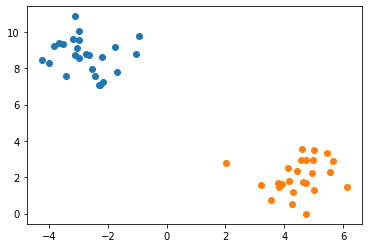

In [40]:
def plot_clusters(X, Y):
    fig, ax = plt.subplots()

    clusters = np.unique(Y)
    for c in clusters:
        mask = Y == c
        subset = X[mask]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            marker = 'o'
        )


plot_clusters(X, Y)

## Unlabel subset and visualize

In [41]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [42]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 25 instances of object 0.0
We have to delabel 23 instances
Found 25 instances of object 1.0
We have to delabel 23 instances

    We have 46 unlabeled data
    Out of 50
    


## Visualize data after delabelling

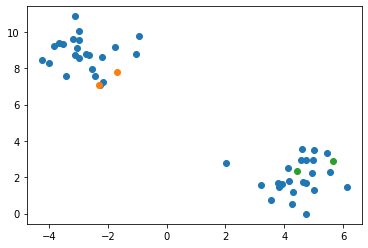

In [43]:
plot_clusters(X, Y_delabeled)

# Gradient Descent method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [44]:
import collections
collections.Counter(Y_delabeled)

Counter({-1000000.0: 46, 0.0: 2, 1.0: 2})

In [46]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

class GradientSolver:
    def __init__(
        self, 
        lr_strategy, 
        learning_rate, 
        similarity_func, 
        bcgd_strategy = None
    ):

        available_lr_strategies = [
            'lr_constant'
        ]
        assert lr_strategy in available_lr_strategies, print(f'Pick available lr_strategy: {available_lr_strategies}')

        self.lr_strategy = lr_strategy
        self.learning_rate = learning_rate
        self.similarity_func = similarity_func

        self.losses = []
        self.n_iterations = 0


    def get_learning_rate(self):
        if self.lr_strategy == 'lr_constant':
            return self.learning_rate   

    def compute_grad_component(self, X, Y, labeled_idxs, unlabeled_idxs, idx):

        grad_component = 0.0
            
        for labeled_idx in labeled_idxs:
            w_ij = self.calc_weight(X[idx], X[labeled_idx])
            # w_ij = np.linalg.norm(X[idx] - X[labeled_idx])
            grad_component += 2 * w_ij * (Y[idx] - Y[labeled_idx])

        for another_unlab_idx in unlabeled_idxs:
            # w_ij_ = np.linalg.norm(X[idx] - X[another_unlab_idx])
            w_ij_ = self.calc_weight(X[idx], X[another_unlab_idx])
            grad_component += 2 * w_ij_ * (Y[idx] - Y[another_unlab_idx])

        return grad_component


    def calc_weight(self, Xi, Xj):
        eps = 0.001
        return 1 / (np.linalg.norm(Xi - Xj) + eps)  # / np.max([np.linalg.norm(Xi), np.linalg.norm(Xj)])

            
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):

        grad = []
        for unlabeled_idx in unlabeled_idxs:
            # compute component of gradient for this 
            # current unlabeled
            grad_component = self.compute_grad_component(X, Y, labeled_idxs, unlabeled_idxs, idx=unlabeled_idx)
            grad.append(grad_component)

        return np.array(grad)

    def compute_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        res = 0
        
        for labeled_idx in labeled_idxs:
            for unlab_idx in unlabeled_idxs:
                w_ij = self.calc_weight(X[labeled_idx], X[unlab_idx])
                # w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
                res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
        
        for unlab_idx in unlabeled_idxs:
            for another_unlab_idx in unlabeled_idxs:
                w_ij = self.calc_weight(X[unlab_idx], X[another_unlab_idx])
                # w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
                res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
        
        return res
    
    def threshold_proc(self, Y_preds):
        Y_preds[Y_preds > 0.5] = 1.0
        Y_preds[Y_preds <= 0.5] = 0.0
        return Y_preds
        

In [50]:
class GradientDescentSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, X, Y, iter_limit, delta_loss_limit):

        labeled_idxs = np.where(Y != DataProperties.unlabeled)[0]
        unlabeled_idxs = np.where(Y == DataProperties.unlabeled)[0]

        Y_res = np.ndarray.copy(Y)
        
        # fix initial approximation
        Y_res[Y_res == DataProperties.unlabeled] = 0.5

        loss_prev = 0.0
        self.losses = []
        self.n_iterations = 0
        for i in range(iter_limit):
            loss = self.compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            print(f'Loss: {loss}, delta loss: {delta_loss}')


            if (i > 0 and delta_loss < delta_loss_limit):
                break
            else:
                grad = self.compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)

                
                
                learning_rate = self.get_learning_rate()
                updates = -learning_rate * grad


                assert len(unlabeled_idxs) == len(grad)
                for i in range(len(grad)):
                    Y_res[unlabeled_idxs[i]] += updates[i]
                
                loss_prev = loss
                self.n_iterations += 1

        # return Y_res
        return self.threshold_proc(Y_res)
        

In [51]:
solver = GradientDescentSolver(
    similarity_func = euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [52]:
Y_preds_GD = solver.solve(
    X,
    Y_delabeled,
    iter_limit = 60,
    delta_loss_limit = 0.001
)

Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.34169528348301, delta 

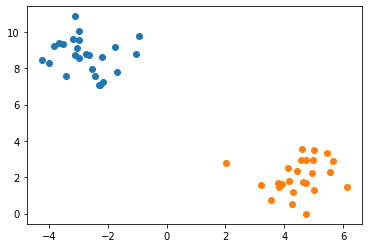

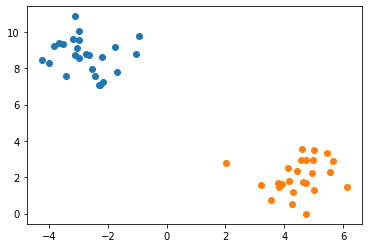

In [53]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)

In [55]:
accuracy_score(Y, Y_preds_GD)

1.0

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [59]:
class BCGDSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        available_strategies = [
            # 'cyclic_order',
            'random permutation',
            'random sampling',
            'cyclic'
        ]

        block_strategy = kwargs['bcgd_strategy']
        assert block_strategy in available_strategies, \
            print(f'Please choose available block strategy: {available_strategies}')
        
        self.block_strategy = block_strategy
        # strategies - random permutation & random sampling

    def pick_block_indices(self, unlabeled_indices):
        
        if self.block_strategy == 'random permutation':
            # we just permute the dimensions
            return np.random.permutation(unlabeled_indices)
        if self.block_strategy == 'random sampling':
            return [random.choice(unlabeled_indices)]
        if self.block_strategy == 'cyclic':
            return unlabeled_indices


    def solve(self, X, Y, iter_limit, delta_loss_limit):

        Y_res = np.ndarray.copy(Y)
        labeled_indices = np.where(Y_res != DataProperties.unlabeled)[0]
        unlabeled_indices = np.where(Y_res == DataProperties.unlabeled)[0]
        assert len(labeled_indices) + len(unlabeled_indices) == len(Y_res)

        # Step 1. Choose initial point
        Y_res[unlabeled_indices] = 0.5

        loss_prev = 0
        self.losses = []
        self.n_iterations = 0
        for i in range(iter_limit):

            loss = self.compute_loss(X, Y_res, labeled_indices, unlabeled_indices)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            loss_prev = loss
            print(f'LOSS: {loss}, Delta: {delta_loss}')

            # Specific condition
            if (i > 0) and delta_loss <= delta_loss_limit:
                break
            else:
                y = np.ndarray.copy(Y_res)  # y_0
                del Y_res

                # depending on the strategy,
                # S contains one random block, permutation
                # of available coordinates, or same sequence of
                # coordinates (for cyclic approach)
                S = self.pick_block_indices(unlabeled_indices)  # Pick random permutation of unlabeled indices
                
                # print(f'Picked: {S}')
                
                # l = len(S)
                # And now we move across S and update y variable
                for index in S:
                    assert(index in unlabeled_indices)
                    learning_rate = self.get_learning_rate()
                    
                    grad_component = self.compute_grad_component(
                        X,
                        y,
                        labeled_indices,
                        unlabeled_indices,
                        idx = index
                    )
                    grad_vector = np.zeros(y.shape[0])
                    grad_vector[index] = grad_component
                    y = y - learning_rate * grad_vector
                
                Y_res = y
                del y
                self.n_iterations += 1
        return self.threshold_proc(Y_res)

In [60]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = euclidian_similarity,

    bcgd_strategy = 'random permutation',
)

In [61]:
Y_preds_BCGD_permutation = random_solver.solve(
    X,
    Y_delabeled,
    iter_limit = 50,
    delta_loss_limit = 0.008
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 24.688851485280132, Delta: 0.4444281502370515
LOSS: 24.29258028494606, Delta: 0.39627120033407337
LOSS: 23.938096826856686, Delta: 0.35448345808937276
LOSS: 23.619828393778672, Delta: 0.3182684330780141
LOSS: 23.333029808331556, Delta: 0.2867985854471158
LOSS: 23.07372626999142, Delta: 0.25930353834013786
LOSS: 22.838445829516083, Delta: 0.2352804404753357
LOSS: 22.624175224736234, Delta: 0.21427060477984838
LOSS: 22.428386110862228, Delta: 0.19578911387400666
LOSS: 22.248854179390573, Delta: 0.17953193147165436
LOSS: 22.083668293623397, Delta: 0.1651858857671762
LOSS: 21.93120122783025, Delta: 0.15246706579314662
LOSS: 21.790003679127995, Delta: 0.1411975487022552
LOSS: 21.65885043334705, Delta: 0.13115324578094345
LOSS: 21.53667011577229, Delta: 0.12218031757476311
LOSS: 21.42250412647334, Delta: 0.11416598929895017
LOSS: 21.315554321933572, Delta: 0.10694980453976655
LOSS: 21.215115762703334, Delta: 0.1004385592302377
LOSS: 2

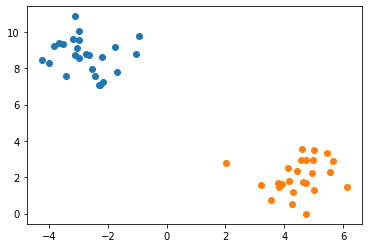

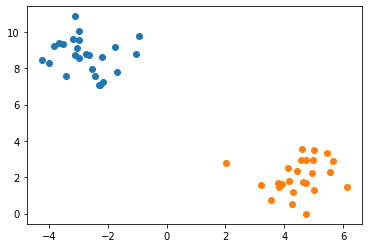

In [62]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)

In [63]:
accuracy_score(Y, Y_preds_BCGD_permutation)

1.0

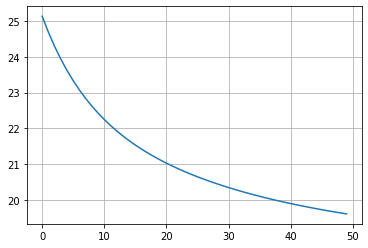

In [64]:
plt.plot(random_solver.losses)
plt.grid()

## BCGD random sampling

In [71]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = euclidian_similarity,

    bcgd_strategy = 'random sampling'
)

In [75]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 100,
    delta_loss_limit = 0.0
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 25.132867690852855, Delta: 0.0004119446643287006
LOSS: 25.13282916754503, Delta: 3.852330782549984e-05
LOSS: 25.132507199782474, Delta: 0.0003219677625558859
LOSS: 25.13193796855172, Delta: 0.000569231230752365
LOSS: 25.131540880422037, Delta: 0.00039708812968441975
LOSS: 25.13097783717709, Delta: 0.0005630432449450495
LOSS: 25.130597068162693, Delta: 0.00038076901439865196
LOSS: 25.097898912886794, Delta: 0.0326981552758987
LOSS: 25.097782090973485, Delta: 0.00011682191330919522
LOSS: 25.097665255436095, Delta: 0.00011683553739061381
LOSS: 25.097627091215735, Delta: 3.81642203599597e-05
LOSS: 25.097592959729017, Delta: 3.413148671782551e-05
LOSS: 25.09750587825038, Delta: 8.708147863600857e-05
LOSS: 25.097493141103314, Delta: 1.273714706684359e-05
LOSS: 25.09684389702773, Delta: 0.0006492440755856421
LOSS: 25.09672631838732, Delta: 0.00011757864040973232
LOSS: 25.09635020265391, Delta: 0.0003761157334096765
LOSS: 25.09619835565

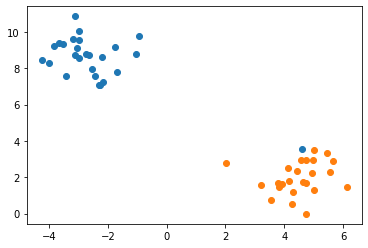

In [76]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)

In [77]:
accuracy_score(
    Y,
    Y_preds_BCGD_sampling
)

0.98

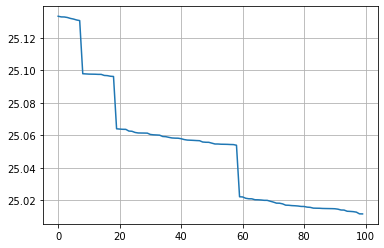

In [78]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [79]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = euclidian_similarity,

    bcgd_strategy = 'cyclic'
)

In [80]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 50, 
    delta_loss_limit = 0.0001
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 24.688868015546948, Delta: 0.4444116199702357
LOSS: 24.292568602572377, Delta: 0.39629941297457094
LOSS: 23.93796895469215, Delta: 0.354599647880228
LOSS: 23.619581106339318, Delta: 0.31838784835283107
LOSS: 23.332703530945338, Delta: 0.28687757539398007
LOSS: 23.073304105379844, Delta: 0.2593994255654941
LOSS: 22.837920845420673, Delta: 0.2353832599591712
LOSS: 22.623577681859683, Delta: 0.21434316356099004
LOSS: 22.427712969374213, Delta: 0.19586471248547
LOSS: 22.248118777142274, Delta: 0.17959419223193862
LOSS: 22.082889311591394, Delta: 0.1652294655508797
LOSS: 21.930377076276837, Delta: 0.15251223531455693
LOSS: 21.789155588986446, Delta: 0.14122148729039097
LOSS: 21.657987657902584, Delta: 0.13116793108386204
LOSS: 21.53579837222916, Delta: 0.12218928567342502
LOSS: 21.42165209247579, Delta: 0.11414627975337055
LOSS: 21.314732835299225, Delta: 0.10691925717656403
LOSS: 21.21432754053694, Delta: 0.10040529476228599
LOSS: 2

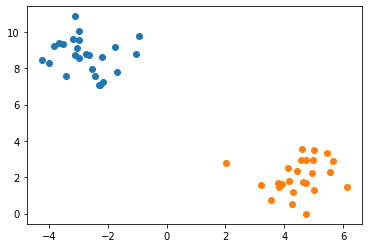

In [81]:
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

In [82]:
accuracy_score(Y, Y_preds_BCGD_cyclic)

1.0

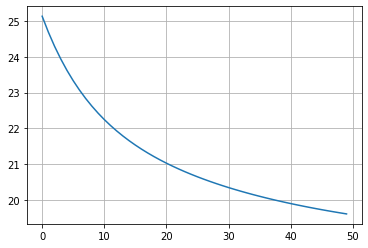

In [83]:
plt.plot(BCGD_cyclic_solver.losses)
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [84]:
learning_rate_strategy = 'lr_constant'
simil_func = euclidian_similarity
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [92]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [93]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [105]:
preds, losses, n_iters, cpu_times = compare_models(
    solvers,
    X,
    Y_delabeled,
    iters_limit = 500,
    delta_loss_limit = 0.003
)

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.34169528348301, delta 

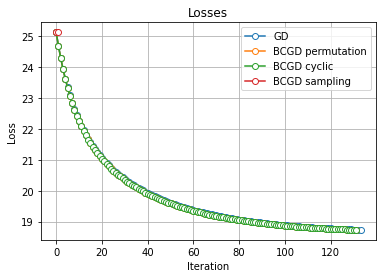

In [106]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots()

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            markerfacecolor = 'white'   
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves(losses, 'Losses', y_label = 'Loss')

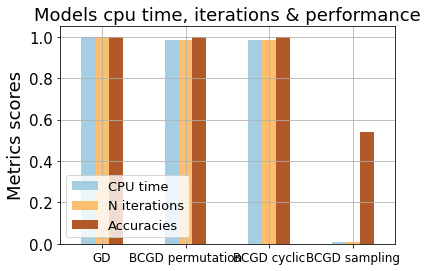

In [107]:
def plot_bar_metrics(metrics_df):
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired'
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

# Real dataset

In [97]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

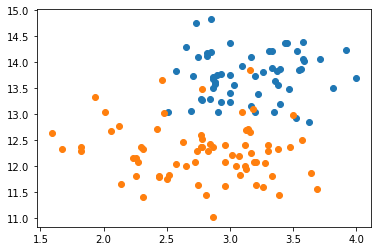

In [98]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [99]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 56 instances
Found 71 instances of object 1.0
We have to delabel 67 instances


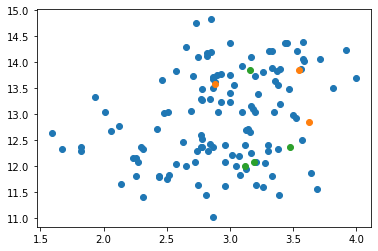

In [100]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

In [103]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = euclidian_similarity
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=500,
    delta_loss_limit = 0.003
)

Loss: 323.8942029624401, delta loss: 323.8942029624401
Loss: 316.74220353972663, delta loss: 7.151999422713459
Loss: 313.4757742177543, delta loss: 3.266429321972339
Loss: 311.76596488709237, delta loss: 1.7098093306619262
Loss: 310.74374644924103, delta loss: 1.0222184378513361
Loss: 310.0575456186789, delta loss: 0.686200830562143
Loss: 309.55204096465934, delta loss: 0.5055046540195463
Loss: 309.15228445531534, delta loss: 0.39975650934400164
Loss: 308.81904661689146, delta loss: 0.33323783842388366
Loss: 308.5303063189672, delta loss: 0.2887402979242779
Loss: 308.2729710189335, delta loss: 0.2573353000336738
Loss: 308.0388864758443, delta loss: 0.2340845430891818
Loss: 307.8227771659063, delta loss: 0.21610930993801958
Loss: 307.6211177640279, delta loss: 0.20165940187843034
Loss: 307.43148312311644, delta loss: 0.18963464091143578
Loss: 307.25215834838053, delta loss: 0.17932477473590325
Loss: 307.0818971554001, delta loss: 0.1702611929804334
Loss: 306.9197681791677, delta loss: 0

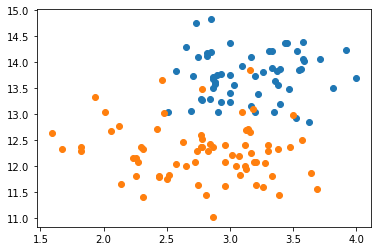

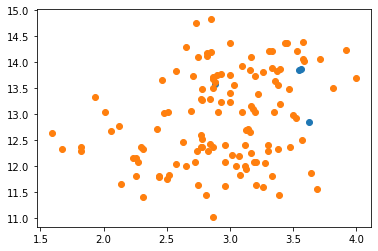

In [104]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)